# Negative covfefe
__The task is to find out which pollsters are more loyal or more prejudiced to Trump.__

### Data:
* __subgroup__ -           The subgroup the poll falls into as defined by the type of people being polled (all polls, voters, adults)
* __startdate__ -         The date the polling began
* __enddate__ -        The date the polling concluded
* __pollster__ -           The polling group which produced the poll
* __grade__ -          The grade for President Trump that the respondents' approval ratings correspond to
* __samplesize__ -        The sample size of the poll
* __population__ -         The type of people being polled (a for adults, lv for likely voters, rv for registered voters)
* __weight__ -             The weight fivethirtyeight gives the poll when determining approval ratings based on historical accuracy of the pollster
* __approve__ -            The percentage of respondents who approve of the president
* __disapprove__ -         The percentage of respondents who disapprove of the president
* __adjusted_approve__ -   The percentage of respondents who approve of the president adjusted for systematic tendencies of the polling firm
* __adjusted_disapprove__ - The percentage of respondents who approve of the president adjusted for systematic tendencies of the polling firm
* __multiversions__ -      True if there are multiple versions of the poll, False if there are not
* __tracking__ -           TRUE if the poll was tracked, FALSE if not
* __url__ -                Poll result URL
* __poll_id__ -            Poll ID number
* __question_id__ -        ID number for the question being polled
* __createddate__ -       Date the poll was created
* __timestamp__ -          Date and time the poll was compiled

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

def clear_data(df):
    # drop columns
    df = df.drop(['president', 'multiversions', 'tracking', 
                  'url', 'influence', 'modeldate',
                  'timestamp', 'grade', ], axis=1)

    return df

# import and clean data
df = clear_data(pd.read_csv('approval_polllist.csv'))
df.head()

,subgroup,startdate,enddate,pollster,samplesize,population,weight,approve,disapprove,adjusted_approve,adjusted_disapprove,poll_id,question_id,createddate
0,All polls,1/20/2017,1/22/2017,Gallup,1500.0,a,0.245429,45.0,45.0,46.19079,43.08462,49253,77265,1/23/2017
1,All polls,1/20/2017,1/22/2017,Morning Consult,1992.0,rv,0.944206,46.0,37.0,43.65441,39.17358,49249,77261,1/23/2017
2,All polls,1/20/2017,1/24/2017,Ipsos,1632.0,a,0.224456,42.1,45.2,42.57524,44.01445,49426,77599,3/1/2017
3,All polls,1/21/2017,1/23/2017,Gallup,1500.0,a,0.226788,45.0,46.0,46.19079,44.08462,49262,77274,1/24/2017
4,All polls,1/20/2017,1/25/2017,Quinnipiac University,1190.0,rv,1.644662,36.0,44.0,37.73200,42.62336,49260,77272,1/26/2017


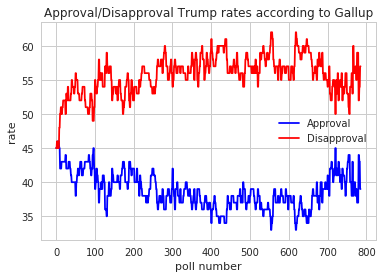

In [49]:
# get approval/disapproval statistics by the name of pollster
def grades_distribution(df, pollster_name):
    pollster = df.loc[df['pollster'] == pollster_name]
    # get approval rates
    rates = [[item[0], item[1]] 
             for item in sorted(list(zip(
                 pollster['approve'].tolist(), pollster['disapprove'].tolist(), pollster['enddate'])), 
                     key=lambda x: datetime.strptime(x[2], '%m/%d/%Y'))]

    return pd.DataFrame.from_dict({'pollster': pd.Series([pollster_name]*len(rates)),
                                   'approval': [item[0] for item in rates], 
                                   'disapproval': [item[1] for item in rates]})

# display approval/disapproval rates according to the pollster sorted by timeline
def show_rates_timeline(dist):
    plt.plot(dist['approval'], color='blue', label='Approval')
    plt.plot(dist['disapproval'], color='red', label='Disapproval')
    plt.title('Approval/Disapproval Trump rates according to {}'.format(dist['pollster'][0]))
    plt.xlabel('poll number')
    plt.ylabel('rate')
    plt.legend()
    plt.show()

# data of Gallup pollster
pollster = 'Gallup'
show_rates_timeline(grades_distribution(df, pollster))

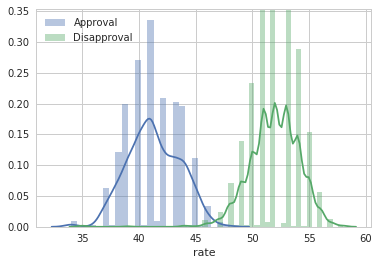

In [50]:
# show rates distribution
def show_rates_dist(dist):
    avl = sns.distplot(dist['approval'].values, hist=True, label='Approval', axlabel='rate')
    disavl = sns.distplot(dist['disapproval'].values, hist=True, label='Disapproval')
    plt.legend()
    plt.show()

pollster = 'YouGov'
show_rates_dist(grades_distribution(df, pollster))

In [51]:
# get all unique pollsters
all_pollsters = pd.Series(list(set(df['pollster'])))
all_pollsters.head()

0    Harris Interactive
1                 Lucid
2               HarrisX
3    Suffolk University
4          SurveyMonkey
dtype: object

# Regression
## __ Response:__
* __net approval rating:__ % approving of Trump in a poll minus % disapproving of Trump.

## __Predictors:__
* __Survey population:__ Adults, Likely voters, Registered voters.
* __Days since the inauguration:__ Calculated as the days between a poll’s end field date and January 20th, 2017.
* __Poll field time:__ Calculated as the difference in days between the start and end date of a poll’s period in the field.
* __No opinion percentage:__ Calculated by subtracting the percent approving and disapproving of Trump from 100, leaving us with people who weren’t sure or had no opinion about Trump in a poll.
* __Pollster:__ survey house which conducted the poll.
* __Subgroup:__ the type of people being polled (all polls, voters, adults)

In [148]:
# data preprocessing
def preprocess(df):
    data = pd.DataFrame()
    # create target value column
    data['net_approval'] = df['approve'] - df['disapprove']
    # create population column
    popul_cvr = {'a': 0, 'rv': 1, 'lv': 2}
    data['population'] = df.apply(lambda x: popul_cvr[x['population']], axis=1)
    # create days_inaug column
    data['days_inaug'] = df.apply(lambda x: 
                                  (datetime.strptime(x['enddate'], '%m/%d/%Y') - 
                                  datetime.strptime('1/20/2017', '%m/%d/%Y')).days, axis=1)
    # create poll_time column
    data['poll_time'] = df.apply(lambda x: (datetime.strptime(x['enddate'], '%m/%d/%Y') -
                                            datetime.strptime(x['startdate'], '%m/%d/%Y')).days, axis=1)
    # create no_opinion column
    data['no_opinion'] = df.apply(lambda x: 100 - (x['approve'] + x['disapprove']), axis=1)
    # create pollster column
    pollster_cvr = {pollster: i for i, pollster in enumerate(all_pollsters)}
    data['pollster'] = df.apply(lambda x: pollster_cvr[x['pollster']], axis=1)
    # create subgroup column
    subgroup_cvr = {'Adults': 0, 'All polls': 1, 'Voters': 2}
    data['subgroup'] = df.apply(lambda x: subgroup_cvr[x['subgroup']], axis=1)
    
    return data

data = preprocess(df)
data.head()

,net_approval,population,days_inaug,poll_time,no_opinion,pollster,subgroup
0,0.0,0,2,2,10.0,18,1
1,9.0,1,2,2,17.0,41,1
2,-3.1,0,4,4,12.7,13,1
3,-1.0,0,3,2,9.0,18,1
4,-8.0,1,5,5,20.0,15,1


In [149]:
import statsmodels.api as sm

X, y = data.loc[:, 'population':'subgroup'].values, data['net_approval'].values
# add intercept
X_train = sm.add_constant(X)
# fit linear model
reg = sm.OLS(y, X_train).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     398.6
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:44:22   Log-Likelihood:                -24636.
No. Observations:                7738   AIC:                         4.929e+04
Df Residuals:                    7731   BIC:                         4.933e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.2313      0.284    -60.737      0.000     -17.787     -16.675
x1             5.0507      0.132     38.249      0.000       4.792       5.310
x2             0.0041      0.000     13.712      0.000       0.003       0.005
x3            -0.1473      0.031     -4.745      0.000      -0.208      -0.086
x4             0.4358      0.032     13.542      0.000       0.373       0.499
x5            -0.0102      0.006     -1.678      0.093      -0.022       0.002
x6            -0.6085      0.118     -5.172      0.000      -0.839      -0.378
==============================================================================
Omnibus:                      148.274   Durbin-Watson:                   1.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.259
Skew:                           0.046   Prob(JB):                     1.15e-67
Kurtosis:                       3.973   Cond. No.                     2.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [150]:
# show p-value for each predictor
for i in range(X.shape[1] + 1):
    print('x{} p-value: {}'.format(i, reg.pvalues[i]))

x0 p-value: 0.0
x1 p-value: 2.5161129968255565e-293
x2 p-value: 2.6646469623033316e-42
x3 p-value: 2.1199760328038596e-06
x4 p-value: 2.6227121098588815e-41
x5 p-value: 0.09344763524213162
x6 p-value: 2.3798466125742248e-07


All p-values are less than 0.05, so variables are statistically significant.

# House effect

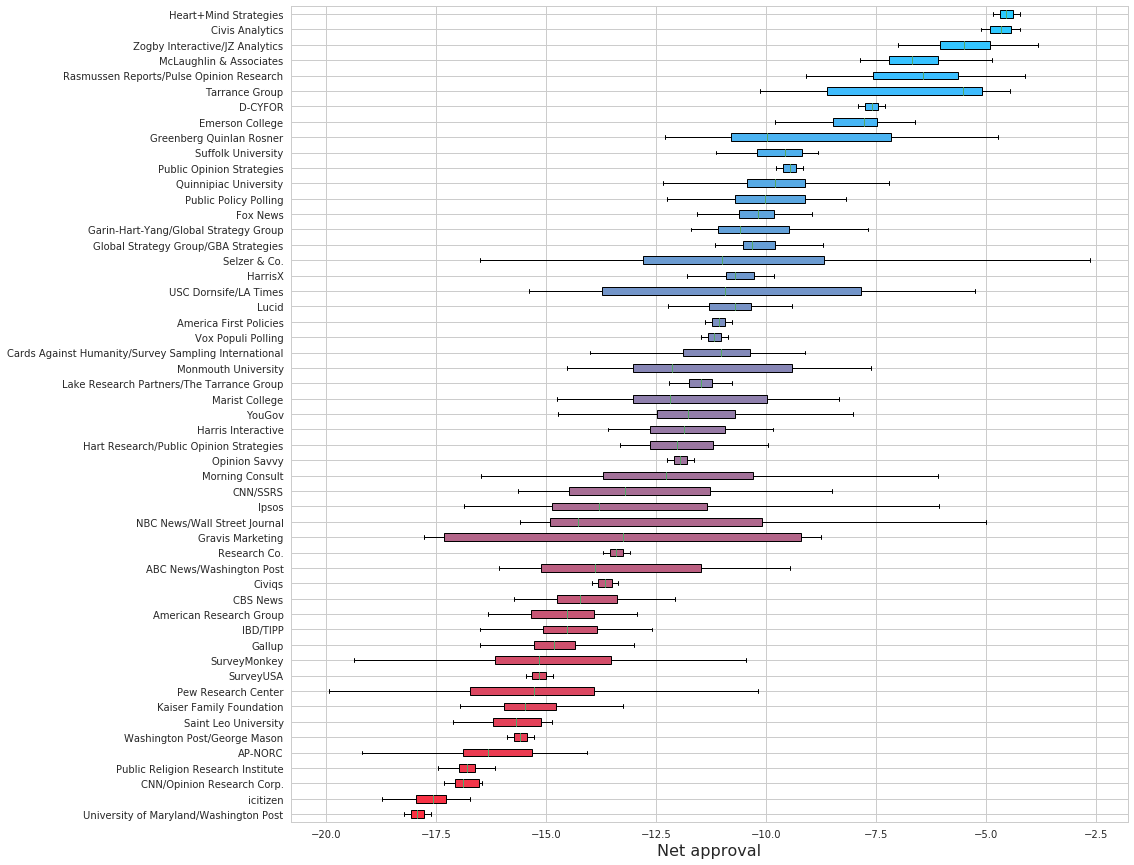

In [151]:
pollster_cvr_inv = {i: pollster for i, pollster in enumerate(all_pollsters)}

boxplot_data = {}
# get data for each pollster from our regression
for i in range(len(all_pollsters)):
    pollster_data = data.loc[data['pollster'] == i].loc[:, 'population':'subgroup'].values
    pollster_data = np.insert(pollster_data, 0, [1]*len(pollster_data), axis=1)
    pred = reg.predict(pollster_data)
    boxplot_data[pollster_cvr_inv[i]] = pred

# display boxplot
plt.rcParams["figure.figsize"] = (15,15)
boxplot_data = np.array(sorted(boxplot_data.items(), key=lambda x: np.mean(np.array(x[1]))))
labels, box_data = boxplot_data[:, 0], boxplot_data[:, 1]

bp = plt.boxplot(box_data, vert=False, labels=labels, patch_artist=True)
start_color, end_color = [[255, 44, 61], [25, 180, 254]]
diff = [round((y - x)/len(labels)) for x, y in zip(start_color, end_color)]

for box in bp['boxes']:
    # change outline color
    box.set(color='black', linewidth=1)
    # change fill color
    start_color = [(x + y) for x, y in zip(start_color, diff)]
    box.set(facecolor=[item/255 if item/255 <= 1 and item/255 >= 0 else 1 for item in start_color])

plt.xlabel('Net approval', fontsize=16)

plt.show()

In [165]:
import plotly.plotly as py
import plotly.graph_objs as go

# get data for each pollster from our regression
barchart_data = {}
for i in range(len(all_pollsters)):
    pollster_data = data.loc[data['pollster'] == i].loc[:, 'population':'subgroup'].values
    pollster_data = np.insert(pollster_data, 0, [1]*len(pollster_data), axis=1)
    pred = reg.predict(pollster_data)
    barchart_data[pollster_cvr_inv[i]] = pred

mean_value = np.mean(np.array([poll for poll_data in barchart_data.values() for poll in poll_data]))
# display barchart
plt.rcParams["figure.figsize"] = (15,15)
barchart_data = np.array(sorted(barchart_data.items(), key=lambda x: np.mean(np.array(x[1]))))
# correct data by the mean value
barchart_data = np.array([[key, np.mean(value) - mean_value] for key, value in barchart_data])
labels, barchart_data = barchart_data[:, 0], barchart_data[:, 1]

plot_data = [
    go.Bar(
        x = labels,
        y = barchart_data,
        base = 0,
        marker=dict(
            color=list(range(len(labels))),
            colorbar=dict(
                title='Effect',
                tickmode = 'array',
                tickvals = []
            ),
            colorscale='Viridis'
        ),
        name = 'effect'
    )
]
layout = go.Layout(
    autosize=False,
    width=500,
    height=500,
    title=go.layout.Title(
        text='House effect of Trump approval rating'
    ),
    xaxis=go.layout.XAxis(
        tickmode='array',
        automargin=True,
        titlefont=dict(size=30),
    ),
    paper_bgcolor='#7f7f7f',
    plot_bgcolor='#c7c7c7'
)

fig = go.Figure(data=plot_data)
py.iplot(fig, filename='base-bar', layout=layout)


The graph above plots the survey house effect for 53 different pollsters when using net rating as the dependent variable, from greatest effect against Trump in violet to greatest effect in favor of his net rating in yellow.